<a href="https://colab.research.google.com/github/RuchirS-spec/Intelligence-Sig-Recs-2025/blob/main/Man_Task_1_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a word embedding model using co-occurence graphs

In [ ]:
!pip install datasets
!pip install spacy
!pip install pykeen
!pip install node2vec

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached node2vec-0.5.0-py3-none-any.whl.metadata (849 bytes)
  Using cached gensim-4.3.3-cp312-cp312-win_amd64.whl.metadata (8.2 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached node2vec-0.5.0-py3-none-any.whl (7.2 kB)
Using cached gensim-4.3.3-cp312-cp312-win_amd64.whl (24.0 MB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
Using cached scipy-1.13.1-cp312-cp312-win_amd64.whl (45.9 MB)

  Attempting uninstall: numpy

    Found existing installation: numpy 2.2.6

    Uninstalling numpy-2.2.6:

   ---------------------------------------- 0/4 [numpy]
 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip uninstall gensim numpy -y
!pip install numpy==1.26.4 # Trying a specific numpy version
!pip install gensim

Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Defaulting to user installation because normal site-packages is not writeable


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


Defaulting to user installation because normal site-packages is not writeable
  Using cached gensim-4.3.3-cp312-cp312-win_amd64.whl.metadata (8.2 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached gensim-4.3.3-cp312-cp312-win_amd64.whl (24.0 MB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)

   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   -----------------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import pandas as pd
from datasets import load_dataset
import spacy
import re
import networkx as nx
import collections
import random
from gensim.models import Word2Vec
import csv
import matplotlib.pyplot as plt

In [ ]:
dataset = load_dataset("lucadiliello/newsqa", split='train')
df = pd.DataFrame(dataset)

In [ ]:
corpus = df['question'][:5000].tolist()

## For creating the co occurence graph

What is a co-occurence graph ?
basically a co-occurence graph has all the nodes as words and edges represent their co-occurence,
if a word appears many times in a sentence it will have multiple "paths" through it
to explain it simply, if we start at any node, the next node if it has multiple edges will provide us with multiple paths to make meaningful sentances

In [ ]:
window_size = 5 #the window size here defines co-occuence.

G = nx.DiGraph()
unique_words = set() #create an empty set to keep track of our unique words.

for sentence in corpus:
  words = [word.lower() for word in str(sentence).split() if word.isalnum()] # I decided to use a basic tokenization method to make each token a word split by space

  for word in words:
    unique_words.add(word)

  for i in range(len(words)):
      for j in range(max(0, i - window_size), min(len(words), i + window_size + 1)):
          if i != j:
            word1 = words[i]
            word2 = words[j]
            if G.has_edge(word1, word2):
              G[word1][word2]['weight'] += 1
            else:
              G.add_edge(word1, word2, weight=1)

In [ ]:
print(G.number_of_edges())
print(G.number_of_nodes())

70225
4149


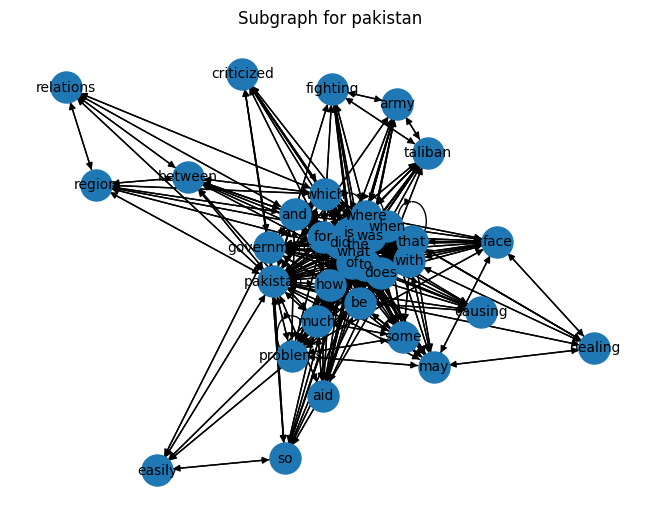

In [ ]:
subgraph_nodes = list(G.neighbors("pakistan")) + ["pakistan"]
subgraph = G.subgraph(subgraph_nodes)
nx.draw(subgraph,with_labels=True, node_size=500,font_size=10)
plt.title("Subgraph for pakistan")
plt.show()

## I use my own simplified version of the infamous node2vec algorithm


In [ ]:
#I implemented my own node embedding logic here cause node2vec's p and q based biased walks needs more data and is way harder to train
#I can use node2vec as a pretrained model but decide to try something out myself :)
walk_length = 30
num_walks = 100
random_walks = []

nodes = list(G.nodes())

for start_node in nodes:
    for _ in range(num_walks):
        current_node = start_node
        walk = [current_node]
        for _ in range(walk_length - 1):
            neighbors = list(G.neighbors(current_node))
            if not neighbors:
                break
            next_node = random.choice(neighbors)
            walk.append(next_node)
            current_node = next_node
        random_walks.append(walk)

In [ ]:
embedding_model = Word2Vec(
    sentences=random_walks,
    vector_size=100,
    window=10,
    min_count=1,
    sg=1,
    workers=4)


In [ ]:
#used gemini here to save the file to csv, :(

output_filename = '/content/newsqa_word_graph2vec_embeddings.csv'

with open(output_filename, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    # Write the header row
    writer.writerow(['word', 'embedding'])

    # Iterate through all words (nodes) in the model's vocabulary
    for word in embedding_model.wv.index_to_key:
        # Get the vector for the word
        embedding_vector = embedding_model.wv[word]

        # Format the vector as a comma-separated string, enclosed in quotes
        embedding_str = ','.join(map(str, embedding_vector))

        # Write the final [word, "embedding_string"] row
        writer.writerow([word, f'"{embedding_str}"'])